x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 2.7632 - lr: 1.9000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 2/500
1/1 [==============================] - 0s 11ms/step - loss: 2.7480 - lr: 1.9000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 3/500
1/1 [==============================] - 0s 11ms/step - loss: 2.7324 - lr: 1.9000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 4/500
1/1 [==============================] - 0s 14ms/step - loss: 2.7170 - lr: 1.9000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 5/500
1/1 [==============================] - 0s 11ms/step - loss: 2.7020 - lr: 1.9000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 

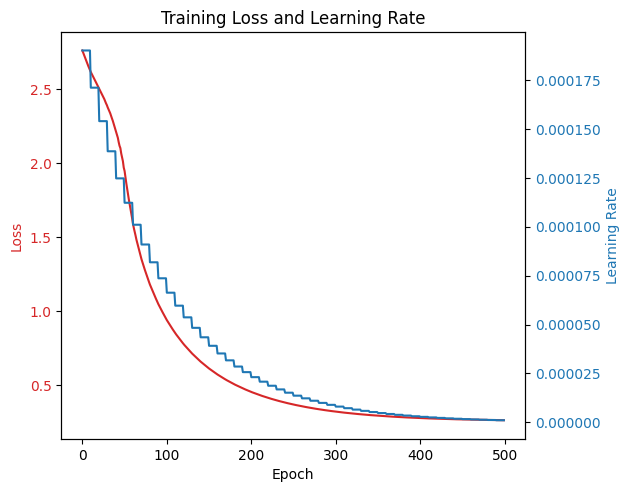

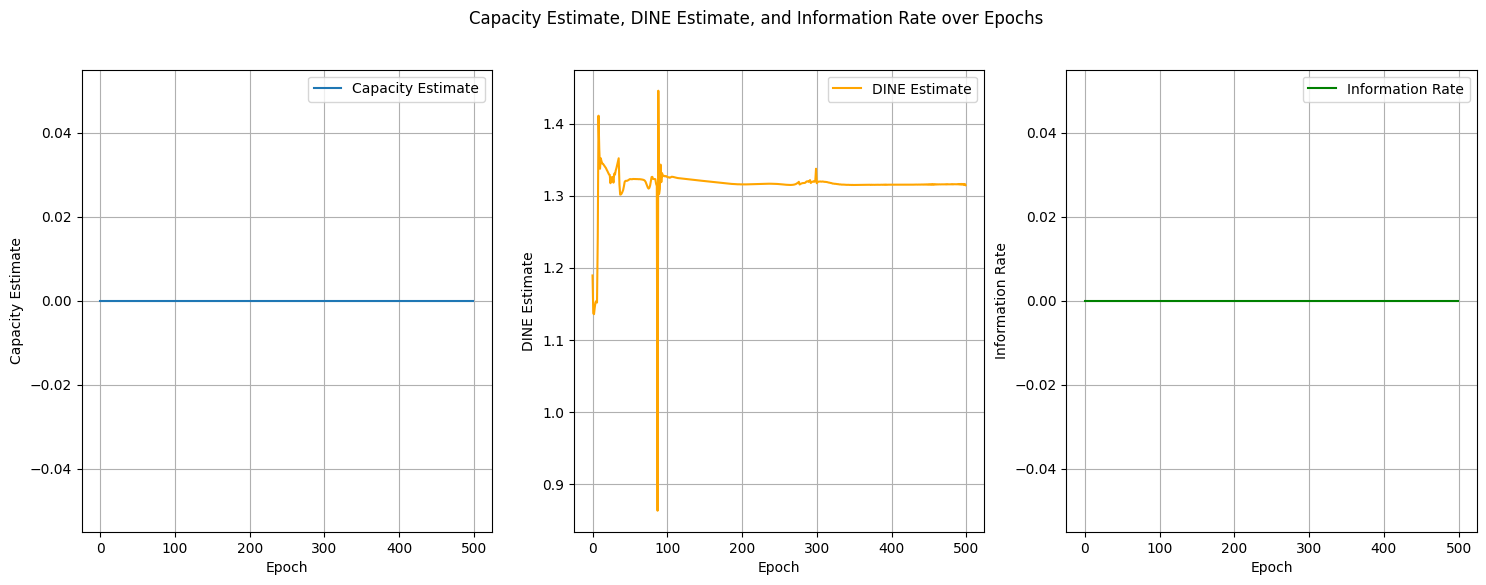

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, metric_name='', **kwargs):
        super(ModelMetrics, self).__init__(name=metric_name, **kwargs)
        self.writer = writer
        self.metric_pool = [
            DV(metric_name='dv_xy_{}'.format(metric_name)),
            DV(metric_name='dv_y_{}'.format(metric_name)),
            DI(metric_name='di_{}'.format(metric_name)),
            PMF(metric_name='p_mean'),
            DI_bits(metric_name='di_bits')
        ]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            result = metric.result()
            if np.isnan(result):
                print(f"NaN detected in metric {metric.name} during epoch {epoch}")
                continue
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, metric_name='dv_loss', **kwargs):
        super(DV, self).__init__(name=metric_name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / (self.global_counter + 1e-10) - K.log(self.exp_T_bar / (self.global_counter_ref + 1e-10))
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, metric_name='di_loss', **kwargs):
        super(DI, self).__init__(name=metric_name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / (self.global_counter + 1e-10) - K.log(self.c_exp_T_bar / (self.global_counter_ref + 1e-10))
        loss_xy = self.xc_T / (self.global_counter + 1e-10) - K.log(self.xc_exp_T_bar / (self.global_counter_ref + 1e-10))
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, metric_name='di_bits_loss', **kwargs):
        super(DI_bits, self).__init__(name=metric_name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / (self.global_counter + 1e-10) - K.log(self.c_exp_T_bar / (self.global_counter_ref + 1e-10))
        loss_xy = self.xc_T / (self.global_counter + 1e-10) - K.log(self.xc_exp_T_bar / (self.global_counter_ref + 1e-10))
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, metric_name='p_mean', **kwargs):
        super(PMF, self).__init__(name=metric_name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / (self.global_counter + 1e-10)
        return result

# class ModelWithEncMetrics(ModelMetrics):
#     def __init__(self, writer, metric_name='ModelWithEncMetrics'):
#         self.writer = writer
#         self.metric_name = metric_name
#         self.metric_pool = [
#             tf.keras.metrics.Mean(name='capacity_estimate'),
#             tf.keras.metrics.Mean(name='info_rate'),
#             CustomMetric(name='di_bits_cap_est_metrics')
#         ]

#     def update_state(self, values):
#         for metric, value in zip(self.metric_pool, values):
#             if tf.reduce_any(tf.math.is_nan(value)):
#                 print(f"NaN detected in value for metric {metric.name}")
#                 continue
#             metric.update_state(value)

#     def result(self):
#         return [metric.result() for metric in self.metric_pool]

#     def reset_states(self):
#         for metric in self.metric_pool:
#             metric.reset_states()

#     def log_metrics(self, epoch, model_name):
#         with self.writer.as_default():
#             for metric in self.metric_pool:
#                 result = metric.result()
#                 if tf.math.is_nan(result):
#                     print(f"NaN detected in metric {metric.name} during epoch {epoch}")
#                     continue
#                 tf.summary.scalar(metric.name, result, epoch)
#         msg = ["{} Epoch: {:05d}\t".format(self.metric_name, epoch)]
#         for metric in self.metric_pool:
#             result = metric.result()
#             if tf.math.is_nan(result):
#                 print(f"NaN detected in metric {metric.name} during epoch {epoch}")
#                 continue
#             msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
#         msg.append(model_name)
#         logger.info("\t".join(msg))

# class CustomMetric(tf.keras.metrics.Metric):
#     def __init__(self, metric_name='custom_metric', **kwargs):
#         # Remove name from kwargs if it exists
#         if 'name' in kwargs:
#             del kwargs['name']
#         super(CustomMetric, self).__init__(name=metric_name, **kwargs)
#         self.total = self.add_weight(name='total', initializer='zeros')
#         self.count = self.add_weight(name='count', initializer='zeros')

#     def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar):
#         # Ensure that NaNs are not introduced in the calculation
#         if tf.reduce_any(tf.math.is_nan(c_T)) or tf.reduce_any(tf.math.is_nan(c_T_bar)) or \
#            tf.reduce_any(tf.math.is_nan(xc_T)) or tf.reduce_any(tf.math.is_nan(xc_T_bar)):
#             print("NaN detected in inputs of custom metric update_state")
#             return

#         # Custom logic for updating state
#         values = (c_T + c_T_bar + xc_T + xc_T_bar) / 4
#         self.total.assign_add(tf.reduce_sum(values))
#         self.count.assign_add(tf.cast(tf.size(values), tf.float32))

#     def result(self):
#         return tf.math.divide_no_nan(self.total, self.count)

#     def reset_states(self):
#         self.total.assign(0.0)
#         self.count.assign(0.0)

class ModelWithEncMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, metric_name='ModelWithEncMetrics', **kwargs):
        super(ModelWithEncMetrics, self).__init__(name=metric_name, **kwargs)
        self.writer = writer
        self.metric_pool = [
            tf.keras.metrics.Mean(name='capacity_estimate'),
            tf.keras.metrics.Mean(name='info_rate'),
            CustomMetric(name='di_bits_cap_est_metrics')
        ]

    def update_state(self, values, **kwargs):
        # Ensure the correct number of arguments are passed for each metric
        for metric, value in zip(self.metric_pool, values):
            if isinstance(metric, CustomMetric):
                if len(value) != 4:
                    print(f"Skipping update for {metric.name}, expected 4 values but got {len(value)}")
                    continue
                metric.update_state(*value)
            else:
                metric.update_state(value)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                result = metric.result()
                if tf.math.is_nan(result):
                    print(f"NaN detected in metric {metric.name} during epoch {epoch}")
                    continue
                tf.summary.scalar(metric.name, result, epoch)
        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            result = metric.result()
            if tf.math.is_nan(result):
                print(f"NaN detected in metric {metric.name} during epoch {epoch}")
                continue
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
        msg.append(model_name)
        logger.info("\t".join(msg))


class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, name='custom_metric', **kwargs):
        # Remove name from kwargs if it exists
        if 'name' in kwargs:
            del kwargs['name']
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        # Ensure that NaNs are not introduced in the calculation
        if tf.reduce_any(tf.math.is_nan(c_T)) or tf.reduce_any(tf.math.is_nan(c_T_bar)) or \
           tf.reduce_any(tf.math.is_nan(xc_T)) or tf.reduce_any(tf.math.is_nan(xc_T_bar)):
            print("NaN detected in inputs of custom metric update_state")
            return tf.constant(0.0)  # Ensure a return value even in the case of NaN detection

        # Custom logic for updating state
        values = (c_T + c_T_bar + xc_T + xc_T_bar) / 4
        self.total.assign_add(tf.reduce_sum(values))
        self.count.assign_add(tf.cast(tf.size(values), tf.float32))
        return tf.constant(1.0)  # Ensure a return value

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)

    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)



class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), metric_name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

            c_T = predictions
            c_T_bar = tf.math.exp(predictions)
            xc_T = predictions * y
            xc_T_bar = tf.math.exp(predictions * y)

            # Debug print statements to check intermediate values
            # print(f"c_T: {c_T.numpy()[:5]}, c_T_bar: {c_T_bar.numpy()[:5]}")
            # print(f"xc_T: {xc_T.numpy()[:5]}, xc_T_bar: {xc_T_bar.numpy()[:5]}")

        self.metrics.metric_pool[2].update_state(c_T, c_T_bar, xc_T, xc_T_bar)

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[1].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.random.uniform(shape=[self.config['batch_size'], 1], minval=0, maxval=1)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

    def mc_evaluation(self, num_simulations=1000):
        results = []
        for _ in range(num_simulations):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            predictions = self.model(x_y_combined, training=False)
            loss = self.loss_fn(y, predictions)
            results.append(loss.numpy())
        return np.mean(results), np.std(results)

    def mdp_evaluation(self, policy, num_steps=100):
        state = self.data_iterators.gen_data()[0]
        total_reward = 0
        for _ in range(num_steps):
            action = policy(state)
            next_state, reward = self.data_iterators.gen_data()
            total_reward += reward.numpy()
            state = next_state
        return total_reward / num_steps

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-10), axis=-1))

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 100,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.00019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=tf.keras.losses.KLDivergence())

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, metric_name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([
        [tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
         tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
         tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32)),
         tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))]
    ])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)


# Monte Carlo Evaluation
mean_loss, std_loss = capacity_estimator.mc_evaluation(num_simulations=1000)
print(f"Monte Carlo Evaluation - Mean Loss: {mean_loss}, Std Loss: {std_loss}")

# MDP Evaluation
def random_policy(state):
    return tf.random.uniform(shape=state.shape, minval=0, maxval=1)

mdp_reward = capacity_estimator.mdp_evaluation(policy=random_policy, num_steps=100)
print(f"MDP Evaluation - Average Reward: {mdp_reward}")

# Final evaluation and reporting
def final_evaluation(capacity_estimator):
    # Monte Carlo Evaluation
    mean_loss, std_loss = capacity_estimator.mc_evaluation(num_simulations=1000)
    print(f"Monte Carlo Evaluation - Mean Loss: {mean_loss}, Std Loss: {std_loss}")

    # MDP Evaluation
    mdp_reward = capacity_estimator.mdp_evaluation(policy=random_policy, num_steps=100)
    print(f"MDP Evaluation - Average Reward: {mdp_reward}")

    return {
        "MC Mean Loss": mean_loss,
        "MC Std Loss": std_loss,
        "MDP Average Reward": mdp_reward
    }

evaluation_results = final_evaluation(capacity_estimator)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, capacity_estimator.info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()


x data check: 0 0
y data check: 0 0

Epoch 1: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 4s 4s/step - loss: 2.8238 - lr: 1.9000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 2/500
1/1 [==============================] - 0s 11ms/step - loss: 2.8067 - lr: 1.9000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 3/500
1/1 [==============================] - 0s 11ms/step - loss: 2.7899 - lr: 1.9000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 4/500
1/1 [==============================] - 0s 16ms/step - loss: 2.7734 - lr: 1.9000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 5/500
1/1 [==============================] - 0s 11ms/step - loss: 2.7571 - lr: 1.9000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001900000061141327.
Epoch 6/500
1/1 [==============================] - 0s 11ms/step - loss: 2.7408 - lr: 1.9000e-04

Epoch 7: LearningRateScheduler settin

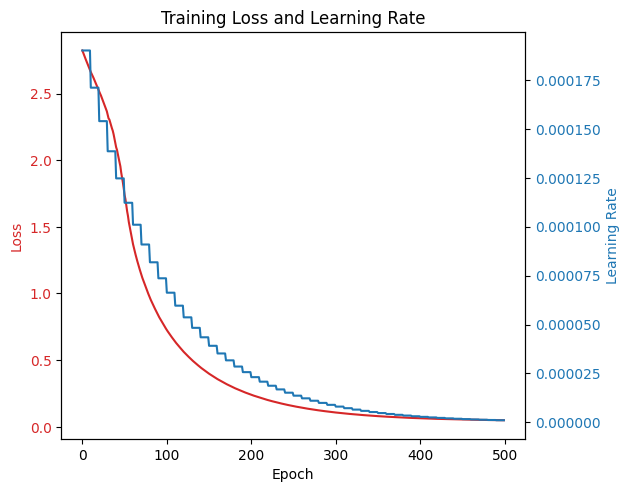

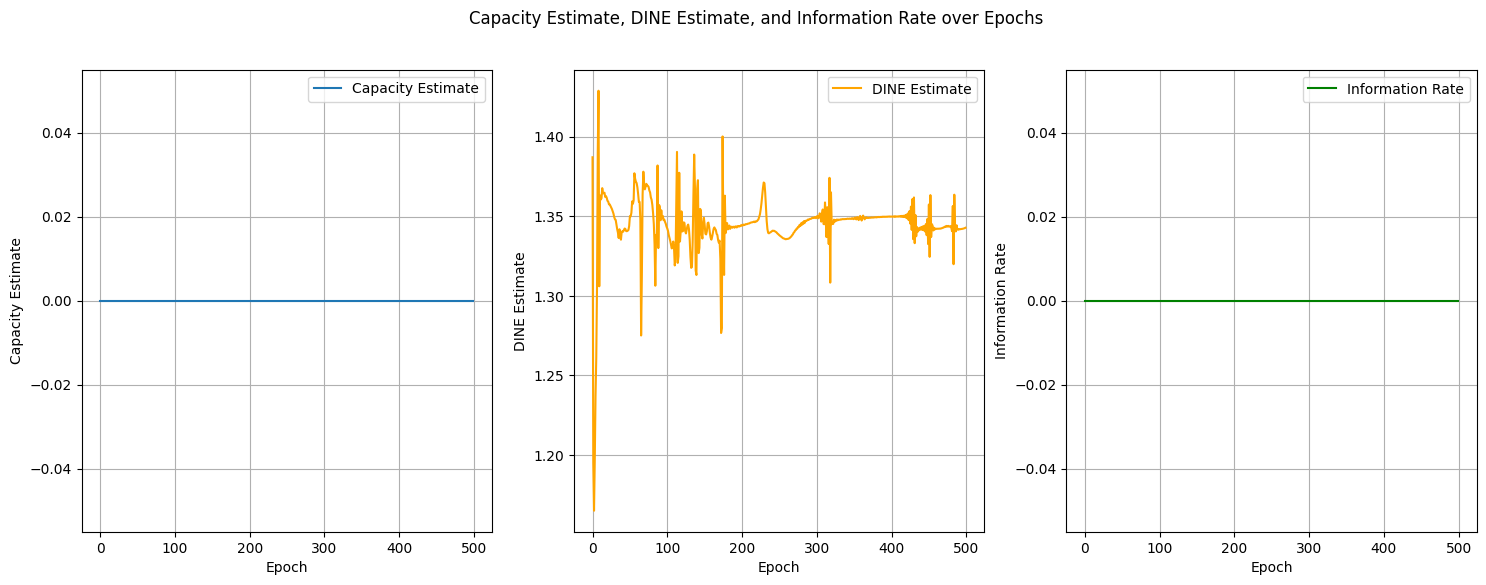

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import logging
import math
import matplotlib.pyplot as plt

logger = logging.getLogger("logger")

class ModelMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, metric_name='', **kwargs):
        super(ModelMetrics, self).__init__(name=metric_name, **kwargs)
        self.writer = writer
        self.metric_pool = [
            DV(metric_name='dv_xy_{}'.format(metric_name)),
            DV(metric_name='dv_y_{}'.format(metric_name)),
            DI(metric_name='di_{}'.format(metric_name)),
            PMF(metric_name='p_mean'),
            DI_bits(metric_name='di_bits')
        ]

    def update_state(self, t_y, t_xy, **kwargs):
        t_y = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_y]
        t_xy = [tf.convert_to_tensor(t, dtype=tf.float32) for t in t_xy]

        if not isinstance(t_y, (list, tuple)) or len(t_y) < 2:
            raise ValueError("Invalid t_y format. Expected lists with at least two elements.")
        if not isinstance(t_xy, (list, tuple)) or len(t_xy) < 2:
            raise ValueError("Invalid t_xy format. Expected lists with at least two elements.")

        self.metric_pool[0].update_state(t_xy[0], t_xy[1])
        self.metric_pool[1].update_state(t_y[0], t_y[1])
        self.metric_pool[2].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])
        self.metric_pool[3].update_state(t_y[0], t_y[1], t_xy[0], t_xy[1])

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()
        return

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                tf.summary.scalar(metric.name, metric.result(), epoch)

        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            result = metric.result()
            if np.isnan(result):
                print(f"NaN detected in metric {metric.name} during epoch {epoch}")
                continue
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
        msg.append(model_name)
        logger.info("\t".join(msg))

class DV(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, metric_name='dv_loss', **kwargs):
        super(DV, self).__init__(name=metric_name, **kwargs)
        self.T = self.add_weight(name='t', initializer='zeros')
        self.exp_T_bar = self.add_weight(name='exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, T, T_bar, **kwargs):
        self.T.assign_add(tf.reduce_sum(T))
        self.exp_T_bar.assign_add(tf.reduce_sum(T_bar))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss = self.T / (self.global_counter + 1e-10) - K.log(self.exp_T_bar / (self.global_counter_ref + 1e-10))
        return loss

class DI(tf.keras.metrics.Metric):  # estimated DI calculation metric class
    def __init__(self, metric_name='di_loss', **kwargs):
        super(DI, self).__init__(name=metric_name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / (self.global_counter + 1e-10) - K.log(self.c_exp_T_bar / (self.global_counter_ref + 1e-10))
        loss_xy = self.xc_T / (self.global_counter + 1e-10) - K.log(self.xc_exp_T_bar / (self.global_counter_ref + 1e-10))
        return loss_xy - loss_y

class DI_bits(tf.keras.metrics.Metric):  # estimated DI calculation metric class in bits
    def __init__(self, metric_name='di_bits_loss', **kwargs):
        super(DI_bits, self).__init__(name=metric_name, **kwargs)
        self.c_T = self.add_weight(name='c_t', initializer='zeros')
        self.c_exp_T_bar = self.add_weight(name='c_exp_t_bar', initializer='zeros')
        self.xc_T = self.add_weight(name='xc_t', initializer='zeros')
        self.xc_exp_T_bar = self.add_weight(name='xc_exp_t_bar', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')
        self.global_counter_ref = self.add_weight(name='n_ref', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        self.c_T.assign_add(tf.reduce_sum(c_T))
        self.c_exp_T_bar.assign_add(tf.reduce_sum(c_T_bar))

        self.xc_T.assign_add(tf.reduce_sum(xc_T))
        self.xc_exp_T_bar.assign_add(tf.reduce_sum(xc_T_bar))

        self.global_counter.assign_add(tf.cast(tf.reduce_prod(c_T.shape[:-1]), dtype=tf.float32))
        self.global_counter_ref.assign_add(tf.cast(tf.reduce_prod(c_T_bar.shape[:-1]), dtype=tf.float32))

    def result(self):
        loss_y = self.c_T / (self.global_counter + 1e-10) - K.log(self.c_exp_T_bar / (self.global_counter_ref + 1e-10))
        loss_xy = self.xc_T / (self.global_counter + 1e-10) - K.log(self.xc_exp_T_bar / (self.global_counter_ref + 1e-10))
        return (loss_xy - loss_y) / math.log(2)

class PMF(tf.keras.metrics.Metric):  # estimated DV loss calculation metric class
    def __init__(self, metric_name='p_mean', **kwargs):
        super(PMF, self).__init__(name=metric_name, **kwargs)
        self.p = self.add_weight(name='p', initializer='zeros')
        self.global_counter = self.add_weight(name='n', initializer='zeros')

    def update_state(self, p, **kwargs):
        self.p.assign_add(tf.reduce_sum(p))
        self.global_counter.assign_add(tf.cast(tf.reduce_prod(p.shape[:-1]), dtype=tf.float32))

    def result(self):
        result = self.p / (self.global_counter + 1e-10)
        return result

# class ModelWithEncMetrics(ModelMetrics):
#     def __init__(self, writer, metric_name='ModelWithEncMetrics'):
#         self.writer = writer
#         self.metric_name = metric_name
#         self.metric_pool = [
#             tf.keras.metrics.Mean(name='capacity_estimate'),
#             tf.keras.metrics.Mean(name='info_rate'),
#             CustomMetric(name='di_bits_cap_est_metrics')
#         ]

#     def update_state(self, values):
#         for metric, value in zip(self.metric_pool, values):
#             if tf.reduce_any(tf.math.is_nan(value)):
#                 print(f"NaN detected in value for metric {metric.name}")
#                 continue
#             metric.update_state(value)

#     def result(self):
#         return [metric.result() for metric in self.metric_pool]

#     def reset_states(self):
#         for metric in self.metric_pool:
#             metric.reset_states()

#     def log_metrics(self, epoch, model_name):
#         with self.writer.as_default():
#             for metric in self.metric_pool:
#                 result = metric.result()
#                 if tf.math.is_nan(result):
#                     print(f"NaN detected in metric {metric.name} during epoch {epoch}")
#                     continue
#                 tf.summary.scalar(metric.name, result, epoch)
#         msg = ["{} Epoch: {:05d}\t".format(self.metric_name, epoch)]
#         for metric in self.metric_pool:
#             result = metric.result()
#             if tf.math.is_nan(result):
#                 print(f"NaN detected in metric {metric.name} during epoch {epoch}")
#                 continue
#             msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
#         msg.append(model_name)
#         logger.info("\t".join(msg))

# class CustomMetric(tf.keras.metrics.Metric):
#     def __init__(self, metric_name='custom_metric', **kwargs):
#         # Remove name from kwargs if it exists
#         if 'name' in kwargs:
#             del kwargs['name']
#         super(CustomMetric, self).__init__(name=metric_name, **kwargs)
#         self.total = self.add_weight(name='total', initializer='zeros')
#         self.count = self.add_weight(name='count', initializer='zeros')

#     def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar):
#         # Ensure that NaNs are not introduced in the calculation
#         if tf.reduce_any(tf.math.is_nan(c_T)) or tf.reduce_any(tf.math.is_nan(c_T_bar)) or \
#            tf.reduce_any(tf.math.is_nan(xc_T)) or tf.reduce_any(tf.math.is_nan(xc_T_bar)):
#             print("NaN detected in inputs of custom metric update_state")
#             return

#         # Custom logic for updating state
#         values = (c_T + c_T_bar + xc_T + xc_T_bar) / 4
#         self.total.assign_add(tf.reduce_sum(values))
#         self.count.assign_add(tf.cast(tf.size(values), tf.float32))

#     def result(self):
#         return tf.math.divide_no_nan(self.total, self.count)

#     def reset_states(self):
#         self.total.assign(0.0)
#         self.count.assign(0.0)

class ModelWithEncMetrics(tf.keras.metrics.Metric):
    def __init__(self, writer, metric_name='ModelWithEncMetrics', **kwargs):
        super(ModelWithEncMetrics, self).__init__(name=metric_name, **kwargs)
        self.writer = writer
        self.metric_pool = [
            tf.keras.metrics.Mean(name='capacity_estimate'),
            tf.keras.metrics.Mean(name='info_rate'),
            CustomMetric(name='di_bits_cap_est_metrics')
        ]

    def update_state(self, values, **kwargs):
        # Ensure the correct number of arguments are passed for each metric
        for metric, value in zip(self.metric_pool, values):
            if isinstance(metric, CustomMetric):
                if len(value) != 4:
                    print(f"Skipping update for {metric.name}, expected 4 values but got {len(value)}")
                    continue
                metric.update_state(*value)
            else:
                metric.update_state(value)

    def result(self):
        return [metric.result() for metric in self.metric_pool]

    def reset_states(self):
        for metric in self.metric_pool:
            metric.reset_states()

    def log_metrics(self, epoch, model_name):
        with self.writer.as_default():
            for metric in self.metric_pool:
                result = metric.result()
                if tf.math.is_nan(result):
                    print(f"NaN detected in metric {metric.name} during epoch {epoch}")
                    continue
                tf.summary.scalar(metric.name, result, epoch)
        msg = ["{} Epoch: {:05d}\t".format(self.name, epoch)]
        for metric in self.metric_pool:
            result = metric.result()
            if tf.math.is_nan(result):
                print(f"NaN detected in metric {metric.name} during epoch {epoch}")
                continue
            msg.append("{:s} {:3.6f}\t".format(metric.name, float(result)))
        msg.append(model_name)
        logger.info("\t".join(msg))


class CustomMetric(tf.keras.metrics.Metric):
    def __init__(self, name='custom_metric', **kwargs):
        # Remove name from kwargs if it exists
        if 'name' in kwargs:
            del kwargs['name']
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, c_T, c_T_bar, xc_T, xc_T_bar, **kwargs):
        # Ensure that NaNs are not introduced in the calculation
        if tf.reduce_any(tf.math.is_nan(c_T)) or tf.reduce_any(tf.math.is_nan(c_T_bar)) or \
           tf.reduce_any(tf.math.is_nan(xc_T)) or tf.reduce_any(tf.math.is_nan(xc_T_bar)):
            print("NaN detected in inputs of custom metric update_state")
            return tf.constant(0.0)  # Ensure a return value even in the case of NaN detection

        # Custom logic for updating state
        values = (c_T + c_T_bar + xc_T + xc_T_bar) / 4
        self.total.assign_add(tf.reduce_sum(values))
        self.count.assign_add(tf.cast(tf.size(values), tf.float32))
        return tf.constant(1.0)  # Ensure a return value

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)

    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)



class CapEstDI(object):
    def __init__(self, model, data, config):
        self.model = model
        self.data_iterators = data
        self.config = config
        self.loss_fn = tf.keras.losses.Huber()
        self.learning_rate = config['lr']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.metrics = ModelWithEncMetrics(tf.summary.create_file_writer(config['tensor_board_dir']), metric_name='cap_est_metrics')
        self.feedback = (config['feedback'] == 1)
        self.T = config['T']
        self.capacity_estimates = []
        self.dine_estimates = []
        self.info_rates = []

    def train_epoch(self, epoch):
        self.metrics.reset_states()
        self.reset_model_states()

        for _ in range(self.config['batches']):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            with tf.GradientTape() as tape:
                predictions = self.model(x_y_combined, training=True)
                loss = self.loss_fn(y, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

            c_T = predictions
            c_T_bar = tf.math.exp(predictions)
            xc_T = predictions * y
            xc_T_bar = tf.math.exp(predictions * y)

            # Debug print statements to check intermediate values
            # print(f"c_T: {c_T.numpy()[:5]}, c_T_bar: {c_T_bar.numpy()[:5]}")
            # print(f"xc_T: {xc_T.numpy()[:5]}, xc_T_bar: {xc_T_bar.numpy()[:5]}")

        self.metrics.metric_pool[2].update_state(c_T, c_T_bar, xc_T, xc_T_bar)

        self.metrics.log_metrics(epoch, model_name="Training")

        # Store estimates
        self.capacity_estimates.append(self.metrics.metric_pool[0].result().numpy())
        self.dine_estimates.append(self.metrics.metric_pool[2].result().numpy())
        self.info_rates.append(self.metrics.metric_pool[1].result().numpy())

    def evaluate(self, epoch):
        self.metrics.reset_states()
        x, y = self.data_iterators.gen_data()
        x_y_combined = tf.concat([x, y], axis=-1)
        predictions = self.model(x_y_combined, training=False)
        loss = self.loss_fn(y, predictions)
        self.metrics.update_state([loss, loss, tf.random.uniform(shape=[self.config['batch_size'], 1], minval=0, maxval=1)])
        self.metrics.log_metrics(epoch, model_name="Evaluation")

    def train(self, num_epochs=None):
        if num_epochs is None:
            num_epochs = self.config.get('num_epochs', 500)

        for epoch in range(num_epochs):
            if epoch % self.config['eval_freq'] == 0:
                self.evaluate(epoch)
            self.train_epoch(epoch)

        self.evaluate(num_epochs)

    def reset_model_states(self):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states') and layer.stateful:
                layer.reset_states()

    def mc_evaluation(self, num_simulations=1000):
        results = []
        for _ in range(num_simulations):
            x, y = self.data_iterators.gen_data()
            x_y_combined = tf.concat([x, y], axis=-1)
            predictions = self.model(x_y_combined, training=False)
            loss = self.loss_fn(y, predictions)
            results.append(loss.numpy())
        return np.mean(results), np.std(results)

    def mdp_evaluation(self, policy, num_steps=100):
        state = self.data_iterators.gen_data()[0]
        total_reward = 0
        for _ in range(num_steps):
            action = policy(state)
            next_state, reward = self.data_iterators.gen_data()
            total_reward += reward.numpy()
            state = next_state
        return total_reward / num_steps

class Ising_Data(object):
    def __init__(self, config):
        self.config = config
        self.p_x = 0.4503
        self.p_ch = 0.5
        self.batch_size = config['batch_size']
        self.bptt = config['bptt']
        self.ising_ch_logits = self.gen_logits(self.p_ch)
        self.ising_x_logits = self.gen_logits(1 - self.p_x)
        self.initialize_channel()

    def gen_logits(self, p):
        p_t = p * tf.ones(shape=[self.batch_size, 1], dtype=tf.float32)
        p_bar_t = tf.ones_like(p_t) - p_t
        logits = tf.math.log(tf.concat([p_bar_t, p_t], axis=1) + 1e-10)
        return logits

    def gen_data(self):
        y_l = []
        x_l = []
        for t in range(self.bptt):
            self.encoder()
            x_l.append(self.x)
            self.channel()
            y_l.append(self.y)
        x = tf.concat(x_l, axis=1)
        y = tf.concat(y_l, axis=1)
        return x, y

    def initialize_channel(self):
        for step in [0, 1]:
            self.encoder(step)
            self.channel(step)

    def encoder(self, step=None):
        if step == 0:
            self.s_past = tf.zeros(shape=[self.batch_size, 1, 1], dtype=tf.float32)
            self.x = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            self.x = tf.expand_dims(self.x, axis=-1)
        elif step == 1:
            self.x = self.x
        else:
            z = tf.cast(tf.random.categorical(logits=self.ising_x_logits, num_samples=1), dtype=tf.float32)
            z = tf.expand_dims(z, axis=-1)
            x_p = tf.math.floormod(self.x + z, 2)
            x_new = tf.where(tf.equal(self.y, self.s_past), self.s, x_p)
            self.x = x_new

    def channel(self, step=None):
        z = tf.cast(tf.random.categorical(logits=self.ising_ch_logits, num_samples=1), dtype=tf.float32)
        z = tf.expand_dims(z, axis=-1)
        if step == 0:
            self.s = self.s_past
        self.y = tf.where(tf.equal(z, 0), self.x, self.s)
        self.s_past = self.s
        self.s = self.x

def complex_lstm_model_v3(input_shape, config):
    randN_05 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
    bias_init = tf.keras.initializers.Constant(0.01)

    if config['compression_flag'] == 1:
        DV_hidden = config['hidden_size_compression']
    else:
        DV_hidden = config['hidden_size']

    max_norm = config['max_norm_y']

    inputs = tf.keras.Input(shape=input_shape, batch_size=config['batch_size'])
    x = tf.keras.layers.LSTM(DV_hidden[0], return_sequences=True, stateful=True, dropout=config['dropout'], recurrent_dropout=config['dropout'])(inputs)
    x = tf.keras.layers.Dense(DV_hidden[1], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    x = tf.keras.layers.Dense(DV_hidden[2], activation="relu", kernel_initializer=randN_05, bias_initializer=bias_init)(x)
    outputs = tf.keras.layers.Dense(1, activation=config['output_activation'], kernel_initializer=randN_05, bias_initializer=bias_init, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=max_norm))(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(self.model.optimizer.learning_rate.numpy())

def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-10), axis=-1))

# Configuration
config = {
    'GE_b': 0.0005,
    'GE_g': 0.0015,
    'GE_p_b': 0.5,
    'GE_p_g': 0.02,
    'T': 3,
    'alphabet_size': 2,
    'batch_size': 100,
    'batch_size_eval': 5000,
    'batches': 15,
    'bptt': 6,
    'channel_name': 'trapdoor',
    'clip_grad_norm': 1,
    'clip_grad_norm_enc': 0.2,
    'clip_grad_norm_q': 100,
    'clip_likelihood_ratio': [-10.0, 10.0],
    'compression_flag': 0,
    'config': './configs/capacity_estimation.json',
    'contrastive_duplicates': 5,
    'data_name': 'encoder',
    'decay': 0,
    'dropout': 0,
    'dtype': 'binary',
    'enc_dropout': 0.0,
    'enc_hidden': [100, 50],
    'enc_hidden_lstm': 50,
    'enc_last_hidden': 1,
    'eta_post': 0.5,
    'eval_epoch_len': 500,
    'eval_freq': 200,
    'exp_name': 'cap_est',
    'feedback': 1,
    'hidden_size': [100, 150, 10],
    'hidden_size_compression': [100, 2, 100],
    'long_eval_epoch_len': 100,
    'lr': 0.00019,
    'lr_SGD': 0.2,
    'max_norm_xy': 5,
    'max_norm_y': 5,
    'model_name': 'cap_est',
    'noise_layer_q_std': 0.05,
    'num_epochs': 500,
    'optimizer': 'adam',
    'p_bec': 0.3,
    'p_bsc': 0.5,
    'p_ising': 0.5,
    'p_post': 0.5,
    'p_trapdoor': 0.5,
    'p_z': 0.9,
    'q_lstm_units': 25,
    'q_train_freq': 5,
    'quiet': False,
    'reset_channel': 0,
    'run_name': 'ff',
    's_alphabet': 2,
    'seed': 468695,
    'tag_name': 'temp_debugging',
    'tensor_board_dir': './results/cap_est/encoder/ff/temp_debugging/2024-06-17_14-22-31_468695',
    'train_epoch_len': 50,
    'trainer_name': 'cap_est',
    'using_wandb': 0,
    'visualize_epoch_len': 50,
    'weight_decay': 0.0,
    'with_p': 0,
    'x_dim': 1,
    'y_im': 1,
    'output_activation': 'linear'
}

# Initialize the data generator
ising_data = Ising_Data(config)
x, y = ising_data.gen_data()

print("x data check:", np.isnan(x).sum(), np.isinf(x).sum())
print("y data check:", np.isnan(y).sum(), np.isinf(y).sum())

x_y_combined = tf.concat([x, y], axis=-1)

input_shape = (config['bptt'], 2)
complex_model_v3 = complex_lstm_model_v3(input_shape, config)

optimizer = tf.keras.optimizers.Adam(learning_rate=config['lr'], clipnorm=1.0)
complex_model_v3.compile(optimizer=optimizer, loss=negative_log_likelihood)

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
loss_history = LossHistory()

# Train the model to capture the loss history
complex_model_v3.fit(x_y_combined, y, epochs=config['num_epochs'], batch_size=config['batch_size'], callbacks=[callback, loss_history])

# Initialize metrics
writer = tf.summary.create_file_writer(config['tensor_board_dir'])
metrics = ModelWithEncMetrics(writer, metric_name='training_metrics')

# Initialize the capacity estimation object
capacity_estimator = CapEstDI(complex_model_v3, ising_data, config)

# Training loop with learning rate scheduler
# Training loop with learning rate scheduler
for epoch in range(config['num_epochs']):
    capacity_estimator.train_epoch(epoch)
    metrics.update_state([
        [tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
         tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32),
         tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32)),
         tf.zeros_like(tf.convert_to_tensor(loss_history.losses[-1], dtype=tf.float32))]
    ])
    metrics.log_metrics(epoch, model_name='Training')

    if epoch % config['eval_freq'] == 0:
        capacity_estimator.evaluate(epoch)


# Monte Carlo Evaluation
mean_loss, std_loss = capacity_estimator.mc_evaluation(num_simulations=1000)
print(f"Monte Carlo Evaluation - Mean Loss: {mean_loss}, Std Loss: {std_loss}")

# MDP Evaluation
def random_policy(state):
    return tf.random.uniform(shape=state.shape, minval=0, maxval=1)

mdp_reward = capacity_estimator.mdp_evaluation(policy=random_policy, num_steps=100)
print(f"MDP Evaluation - Average Reward: {mdp_reward}")

# Final evaluation and reporting
def final_evaluation(capacity_estimator):
    # Monte Carlo Evaluation
    mean_loss, std_loss = capacity_estimator.mc_evaluation(num_simulations=1000)
    print(f"Monte Carlo Evaluation - Mean Loss: {mean_loss}, Std Loss: {std_loss}")

    # MDP Evaluation
    mdp_reward = capacity_estimator.mdp_evaluation(policy=random_policy, num_steps=100)
    print(f"MDP Evaluation - Average Reward: {mdp_reward}")

    return {
        "MC Mean Loss": mean_loss,
        "MC Std Loss": std_loss,
        "MDP Average Reward": mdp_reward
    }

evaluation_results = final_evaluation(capacity_estimator)

# Plotting loss and learning rate
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(len(loss_history.losses)), loss_history.losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(range(len(loss_history.lr)), loss_history.lr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Learning Rate')
plt.show()

# Plotting the results for Capacity Estimate, DINE Estimate, and Information Rate
epochs = list(range(config['num_epochs']))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Capacity Estimate
axs[0].plot(epochs, capacity_estimator.capacity_estimates, label='Capacity Estimate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Capacity Estimate')
axs[0].legend()
axs[0].grid(True)

# Plot DINE Estimate
axs[1].plot(epochs, capacity_estimator.dine_estimates, label='DINE Estimate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('DINE Estimate')
axs[1].legend()
axs[1].grid(True)

# Plot Information Rate
axs[2].plot(epochs, capacity_estimator.info_rates, label='Information Rate', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Information Rate')
axs[2].legend()
axs[2].grid(True)

plt.suptitle('Capacity Estimate, DINE Estimate, and Information Rate over Epochs')
plt.show()
